In my analysis of Emerald Equity's East Harlem portfolio, I compare HPD violations, DOB & HPD complaints and HPD Litigations in Emerald Equity buildings and buildings in East Harlem.

I used ~nyc-db~, a SQL database built and maintained by Ziggy and freely available here:  https://github.com/aepyornis/nyc-db, to obtain data from different city agencies and to convert to/from BBL and BIN (different ways of denominating a building).

In [18]:
import matplotlib
import pandas as pd
import re
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
pd.set_option('display.max_colwidth', -1)

In [19]:

#Read in the csv. Throw out bad lines-- there are just a few of the 9000-- and suppress warnings.
filepath = "./emerald_equity_hpd_violations.csv"
df = pd.read_csv(filepath, error_bad_lines=False, warn_bad_lines=False)

#This table was drawn from the nyc-db database
'''CREATE TABLE emerald_equity_hpd_violations AS 
SELECT novdescription, class, violationstatus, emerald_equity_bin_bbl.bbl AS bbl
FROM hpd_violations
JOIN emerald_equity_bin_bbl
ON hpd_violations.bbl = emerald_equity_bin_bbl.bbl;'''

filepath2 = "./emerald_equity_dob_complaints.csv"
df_dob = pd.read_csv(filepath2)
'''CREATE TABLE emerald_equity_dob_complaints AS
SELECT complaintcategory, status, complaintnumber, inspectiondate, housenumber, housestreet
FROM dob_complaints
JOIN emerald_equity_bin_bbl
ON dob_complaints.bin = emerald_equity_bin_bbl.bin;'''

#This is for all of East Harlem
df_dob_harlem = pd.read_csv('east_harlem_dob_complaints.csv', low_memory=False)

df_recent = pd.read_csv("./emerald_equity_dob_complaints1.csv")
'''CREATE TABLE recent_emerald_equity_dob_complaints AS select complaintcategory, status, complaintnumber, inspectiondate, housenumber, housestreet
FROM dob_complaints
JOIN emerald_equity_bin_bbl
ON dob_complaints.bin = emerald_equity_bin_bbl.bin
WHERE dobrundate > '2017-01-01';'''

harlem_hpd_df = pd.read_csv("./hpd_harlem.csv")
ee_hpd_df = pd.read_csv("./hpd_emerald_equity.csv")

## Department of Buildings (DOB) Complaints

I decided to just pay attention to the first instance of a DOB complaint, since I don't want to overestimate the amount of actual complaints, and this is not such a detailed analysis that I am looking at length of time between opening and closing a case. So I just ignore the repeated complaintnumbers.

In [20]:
df_dob_ee = df_dob
df_dob_ee.drop_duplicates(subset=['complaintnumber'], keep='first',inplace=True)
df_dob_ee['inspectiondate']= pd.to_datetime(df_dob_ee['inspectiondate'], infer_datetime_format=True, errors='ignore')
df_dob_ee = df_dob_ee.groupby('inspectiondate')['complaintcategory'].value_counts().unstack().fillna(0)

### I repeat the process for East Harlem.

In [21]:
df_dob_harlem['inspectiondate'] = pd.to_datetime(df_dob_harlem['inspectiondate'], infer_datetime_format=True, errors='coerce')
df_dob_harlem.drop_duplicates(subset=['complaintnumber'], keep='first',inplace=True)
df_dob_harlem = df_dob_harlem.set_index(pd.DatetimeIndex(df_dob_harlem['inspectiondate']))
df_dob_harlem = df_dob_harlem.groupby('inspectiondate')['complaintcategory'].value_counts().unstack().fillna(0)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: 'inspectiondate' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  after removing the cwd from sys.path.


In [22]:
#Sum all of the columns: for this part, we do not care about types of DOB complaints.
df_dob_harlem['summed'] = df_dob_harlem.sum(axis=1)

#sum up the columns for the other DF
df_dob_ee['summed'] = df_dob_ee.sum(axis=1)

# I wanted to get the per-building number, so I could make a meaningful comparison.

There are 49 buildings in my Emerald Equity dataset, and 3087 in East Harlem. I tried this first:

In [23]:
df_dob_ee['Emerald_Equity']=df_dob_ee['summed']/49
df_dob_harlem['East_Harlem']=df_dob_harlem['summed']/3087

## But later I realized that this is not reliable: since some buildings have few units, and others have many. The way to go is by residential unit, since those are the units that would be making a complaint:
```
select sum(unitsres)
FROM pluto_17v1
JOIN emerald_equity_bin_bbl
ON
pluto_17v1.bbl = emerald_equity_bin_bbl.bbl;
 sum  
------
 1449
(1 row)
```

and for East Harlem, I ran the same query in nyc-db:

```
select sum(unitsres)
FROM pluto_17v1
WHERE zipcode = '10029' OR zipcode = '10035';
  sum  
-------
 51170
(1 row)
```



In [24]:
# Find the amount of dob complaints per 1000 units

df_dob_ee['Emerald_Equity']=df_dob_ee['summed']/1449 * 1000
df_dob_harlem['East_Harlem']=df_dob_harlem['summed']/51170 * 1000

df_dob_harlem.reset_index().set_index('inspectiondate', inplace=True)
df_dob_ee.reset_index().set_index('inspectiondate', inplace=True)

## Now, I want to plot my data as quickly as possible-- to see if there are any significant trends before I get further invested.

I plot the number of DOB complaints for East Harlem and Emerald Equity over time.

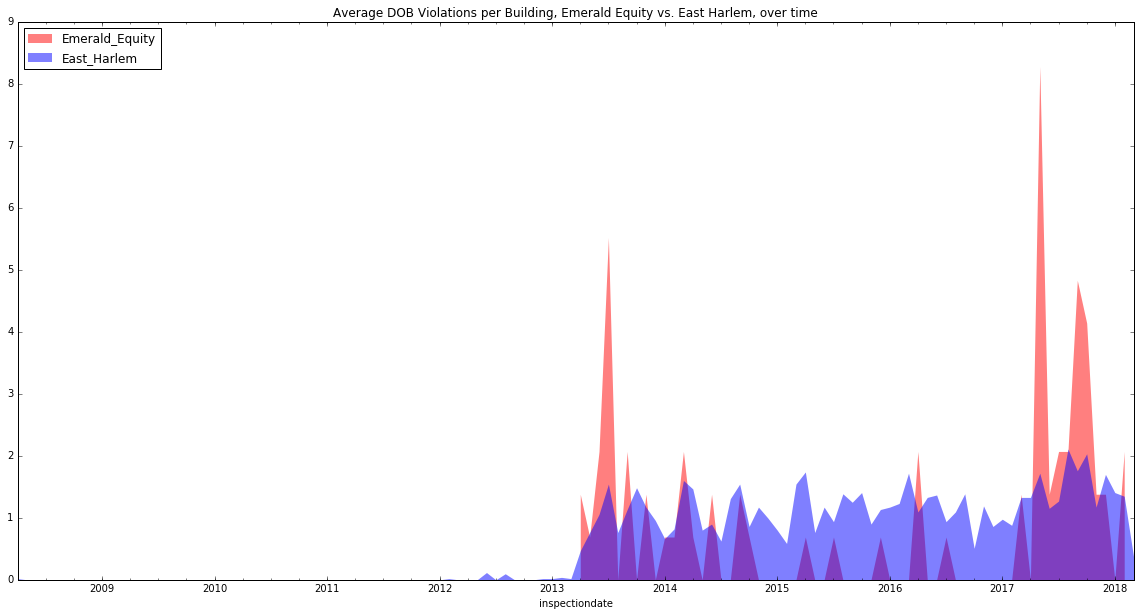

In [26]:
ax = df_dob_ee.resample('M').sum().plot(kind='area', y='Emerald_Equity', figsize = (20, 10), legend=True, linewidth=0, color='red', alpha=.5)
df_dob_harlem.resample('M').sum().plot(kind='area', y='East_Harlem', figsize = (20, 10), legend=True, linewidth=0, color='blue', alpha=.5, ax=ax)
plt.savefig("DOB_overtime.png")
plt.title("Average DOB Violations per Building, Emerald Equity vs. East Harlem, over time")

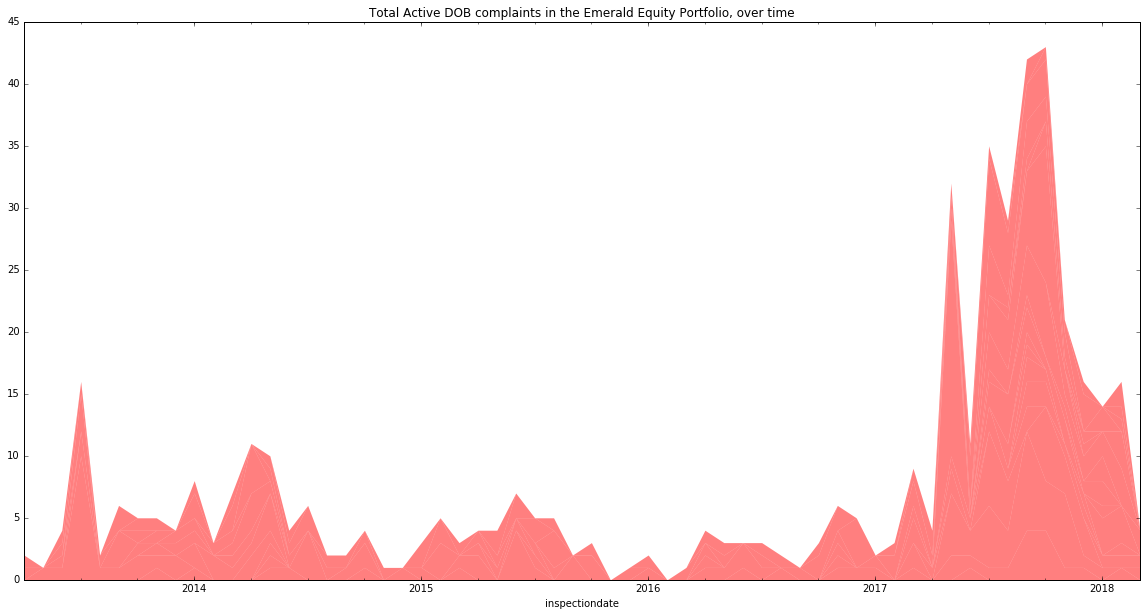

In [163]:
#This counts all violations, regardless of number of times inspected/reupped/closed.
df_dob = pd.read_csv(filepath2)
df_dob['inspectiondate']= pd.to_datetime(df_dob['inspectiondate'], infer_datetime_format=True, errors='ignore')
df_dob_zoom = df_dob
df_dob = df_dob.groupby('inspectiondate')['complaintcategory'].value_counts().unstack().fillna(0)
df_dob.resample('M').sum().plot(kind='area', stacked=True, figsize = (20, 10), legend=False, linewidth=0, color='red', alpha=.5)
plt.title("Total new DOB complaints in the Emerald Equity Portfolio, over time")
plt.savefig("DOB_overtime.png")


In [164]:
purchase=datetime.date(2016,12,27)

df_dob_zoom = df_dob_zoom[df_dob_zoom['inspectiondate']>purchase]
df_dob_zoom = df_dob_zoom.groupby('inspectiondate')['complaintcategory'].value_counts().unstack().fillna(0)

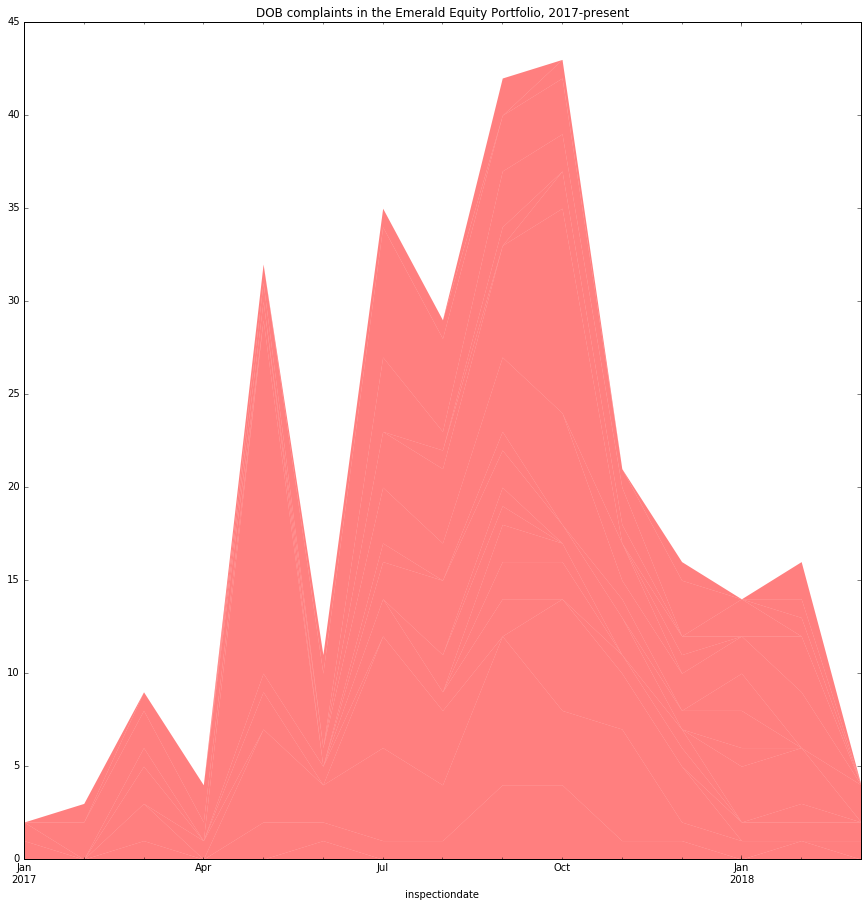

In [165]:
#This also counts repeated complaint numbers.

df_dob_zoom.resample('M').sum().plot(kind='area', stacked=True, figsize = (15, 15), legend=False, linewidth=0, color='red', alpha=.5)
plt.title("DOB complaints in the Emerald Equity Portfolio, 2017-present")
plt.savefig("DOB_overtime_zoom.png")

In [166]:
# Change the date to datetime, and set it as the index
ee_hpd_df['receiveddate']= pd.to_datetime(ee_hpd_df['receiveddate'], infer_datetime_format=True, errors='ignore')
ee_hpd_df.set_index('receiveddate', inplace=True)

In [167]:
# Change the date to datetime, and set it as the index
harlem_hpd_df['receiveddate']= pd.to_datetime(harlem_hpd_df['receiveddate'], infer_datetime_format=True, errors='raise')
harlem_hpd_df.set_index('receiveddate', inplace=True)

#normalize both by total number of buildings in the subset. These are numbers from Pluto_17v1
'''SQL:
SELECT COUNT (DISTINCT bbl) FROM pluto_17v1 WHERE zipcode = '10029' OR zipcode = '10035';
 count 
-------
  3087
(1 row)'''

'''SELECT COUNT (DISTINCT bbl) FROM emerald_equity_bin_bbl;
 count 
-------
    55
(1 row)'''


ee_hpd_df['Emerald_Equity_Count'] = ee_hpd_df['count']/55
harlem_hpd_df['East_Harlem_Count'] = harlem_hpd_df['count']/3087

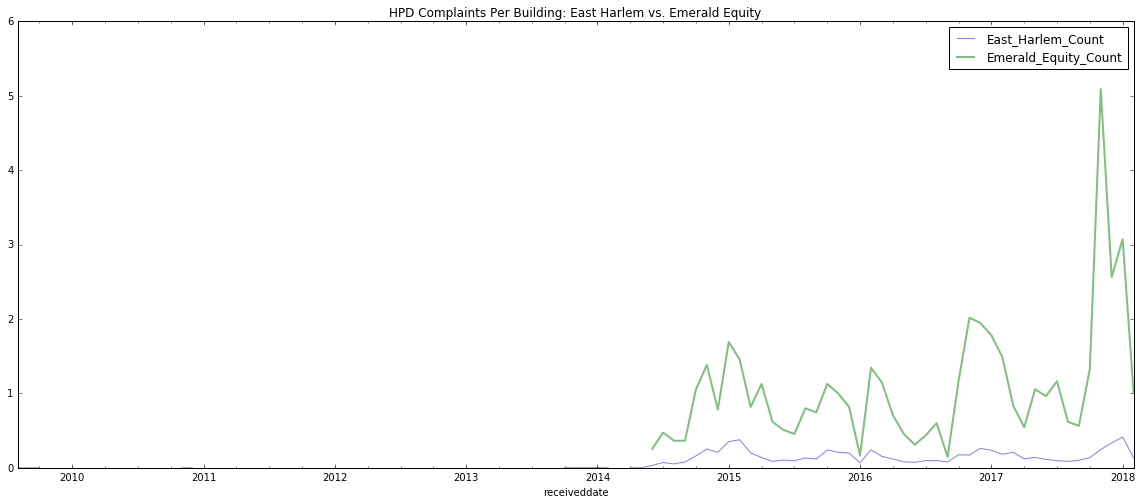

In [168]:
#Drop the original count columns, this looks better for the key
ee_hpd_df.drop('count',axis=1,inplace=True)
harlem_hpd_df.drop('count',axis=1,inplace=True)

#Plot the things
ax = harlem_hpd_df.resample('M').sum().plot(kind='line', alpha=.5, color='blue')
ee_hpd_df.resample('M').sum().plot(kind='line', alpha=.5, color='green', figsize =(20,8),linewidth=2, ax=ax)

#Set the title
plt.title("HPD Complaints Per Building: East Harlem vs. Emerald Equity")


In [2]:
import pandas as pd
df = pd.read_csv("hpd_violations_date_class.csv")

df['date']= pd.to_datetime(df['date'], infer_datetime_format=True, errors='ignore')
df.set_index('date', inplace=True)

In [11]:
df.resample("6M").sum().fillna(0).to_csv("hpd_violations_date_class")

,A,B,C
date,,,
1990-10-30,1.0,0.0,0.0
1992-03-24,0.0,0.0,2.0
1993-12-21,0.0,0.0,1.0
1994-02-22,0.0,0.0,2.0
1994-03-15,0.0,0.0,2.0
1994-04-12,0.0,0.0,3.0
1994-05-03,0.0,1.0,0.0
1994-05-17,0.0,2.0,0.0
1994-07-05,0.0,0.0,1.0
